# NLP处理输出数据的基本步骤
- **Step1**: Tokenize (text to words)
- **Step2**: 构建词典，计算每个词的frequencies，可以取频率最高的一部分（如前k个）
> 去掉低频词的作用：1、**姓名**的频率低，且没有意义；2、**错词**的频率低，且没有意义；3、可以减少vocabulary的大小，过大的话会过拟合（因为更复杂了）
- **Step3**: one-hot encoding（不在vocabulary里面的词可以忽略或者为0）-->sequences
- **Step4**: 对齐sequences  
- **Step5**: embedding  $x = p * e_i$ 
    ，其中，x:[d, 1]; p:[d, v]; $e_i$ : [v, 1]（表示一个词向量）

# Simple RNN 模型
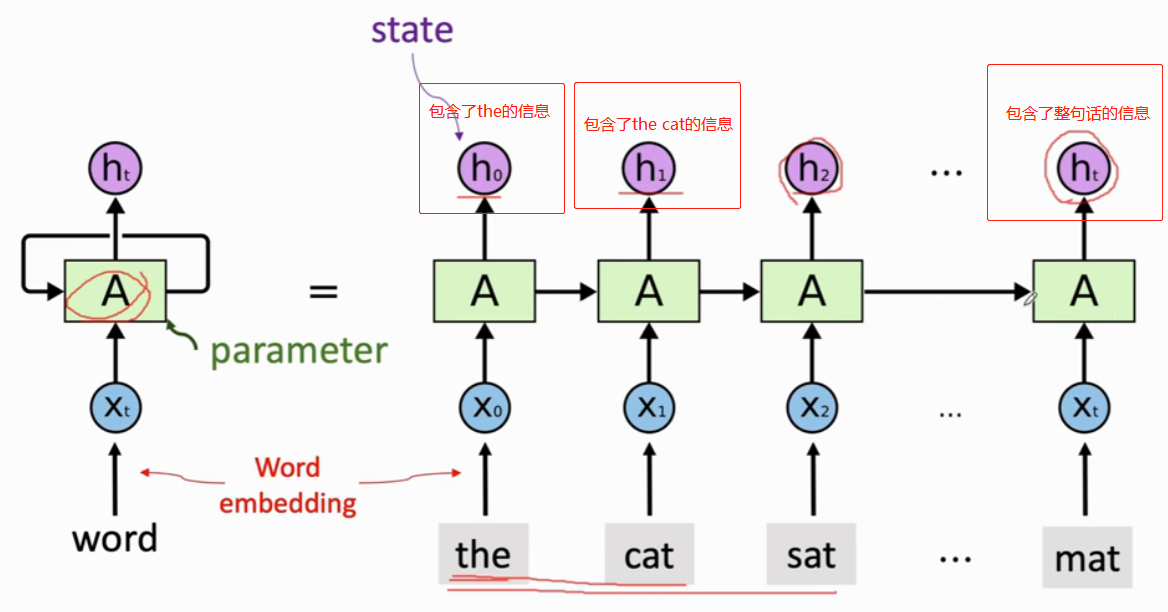
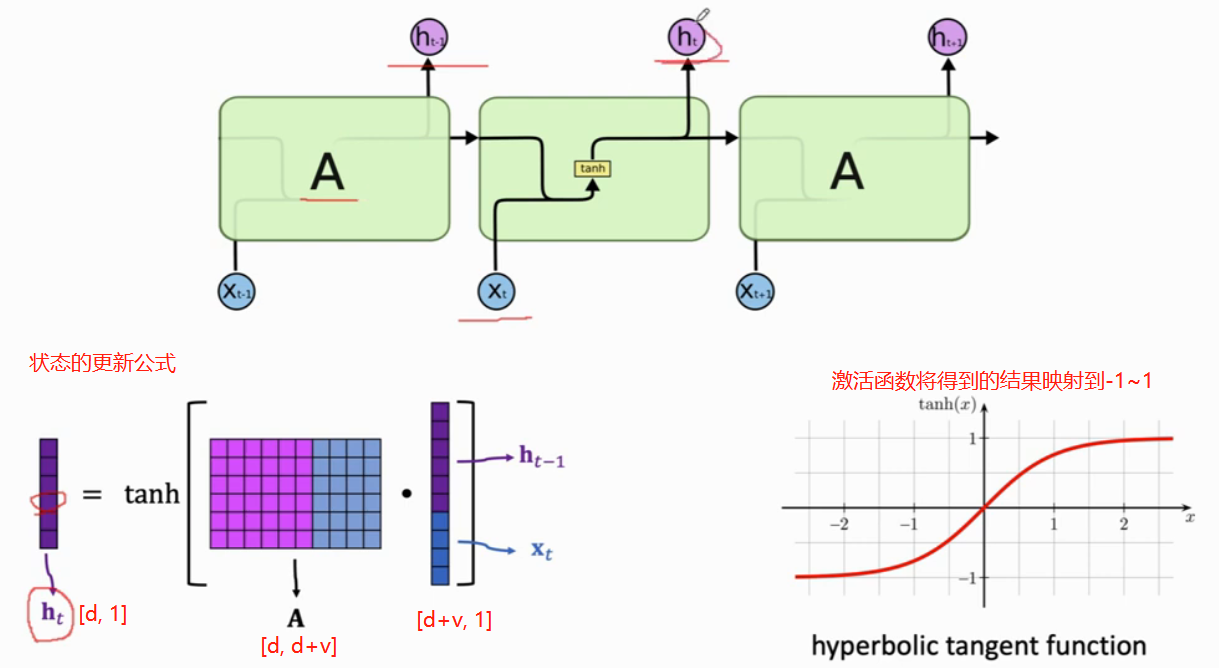 状态$h_t$依赖于$h_{t-1}$, matrix A and $x_t$

> 关于为什么需要激活函数（梯度消失和梯度爆炸）
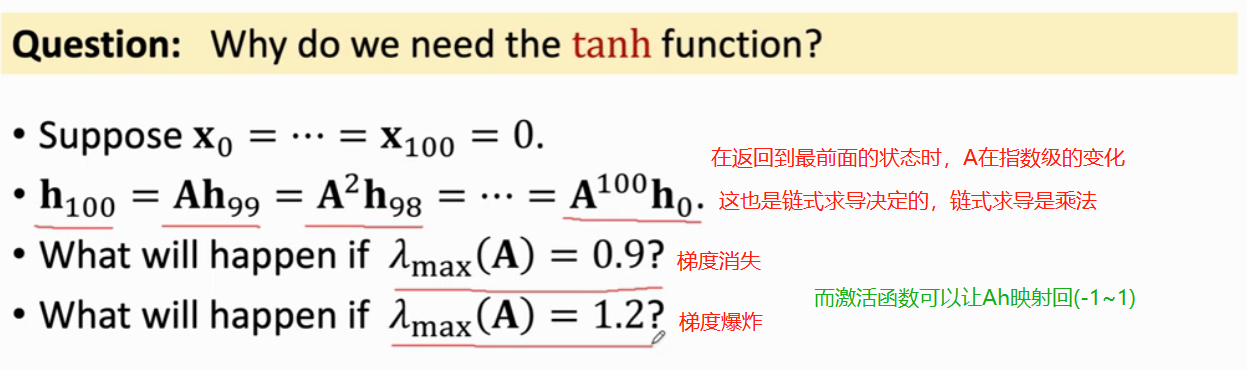

# Simple RNN的keras实现
1. 读取数据

In [15]:
import pandas as pd

train_df = pd.read_csv('./data/data_train.csv', encoding='utf8')
test_df = pd.read_csv('./data/data_test.csv', encoding='utf8')
train_df.head()

,影评内容,真实标签
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1


In [32]:
import re
# 把非英文变成空格，方便划分词汇；然后变成小写，根据空格分开，再拼起来，可以去除多余的空格
train_reviews = train_df['影评内容'].apply(lambda x: ' '.join(re.sub('[^a-zA-Z]', ' ', x).lower().split())).values.tolist()   
test_reviews = test_df['影评内容'].apply(lambda x: ' '.join(re.sub('[^a-zA-Z]', ' ', x).lower().split())).values.tolist()

train_labels = train_df['真实标签'].values
test_labels = test_df['真实标签'].values

len(train_reviews+test_reviews)

50000

In [33]:
# 词化，将text变成sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
token = Tokenizer(num_words=10000)     # 创建词化器，字典容量为10000
token.fit_on_texts(train_reviews+test_reviews)  # 根据训练集和测试集的整体提取词典（fit_on_texts）
word2indx = token.word_index    # word2indx

train_sequences = token.texts_to_sequences(train_reviews)
test_sequences = token.texts_to_sequences(test_reviews)

# 固定长度
x_train = pad_sequences(train_sequences, padding='post', truncating='post', maxlen=500) 
x_test = pad_sequences(test_sequences, padding='post', truncating='post', maxlen=500)

In [38]:
# 构建BiLSTM模型
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Embedding, Dense

vocabulary = 10000   # 词向量维度
word_num = 500       # 句子长度
embedding_dim = 32   # 嵌入维度
state_dim = 32       # 状态维度

model = Sequential()
model.add(Embedding(vocabulary, embedding_dim, input_length=word_num))
model.add(Bidirectional(LSTM(state_dim, return_sequences=False, dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 336,705
Trainable params: 336,705
Non-trainable params: 0
_________________________________________________________________


In [36]:
# 构建SimpleRNN模型
from keras.models import Sequential
from keras.layers import SimpleRNN, Embedding, Dense

vocabulary = 10000   # 词向量维度
word_num = 500       # 句子长度
embedding_dim = 32   # 嵌入维度
state_dim = 32       # 状态维度

model = Sequential()
model.add(Embedding(vocabulary, embedding_dim, input_length=word_num))
model.add(SimpleRNN(state_dim, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


In [39]:
import numpy as np
from tensorflow.keras import optimizers

# indx = np.arange(len(train_labels))    # 生成序列     乱序之后，会对训练产生影响
# np.random.shuffle(indx)                # 打乱序列
epoch = 3

RMS = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=RMS, 
              loss='binary_crossentropy', 
              metrics=['acc'])

history = model.fit(x_train, train_labels, 
                    epochs=epoch, batch_size=32, 
                    validation_split=0.3,verbose=1)

C:\Users\Tang\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/3
547/547 [==============================] - 210s 379ms/step - loss: 0.4702 - acc: 0.7897 - val_loss: 1.4126 - val_acc: 0.4503
Epoch 2/3
547/547 [==============================] - 143s 262ms/step - loss: 0.3073 - acc: 0.8826 - val_loss: 0.8308 - val_acc: 0.5989
Epoch 3/3
547/547 [==============================] - 141s 258ms/step - loss: 0.2561 - acc: 0.9043 - val_loss: 0.4407 - val_acc: 0.8491


In [40]:
# 目前来看，SimpleRNN训练没啥效果
# BiLSTM才有效果
loss, acc = model.evaluate(x_test, test_labels)
print(f'loss:{loss}')
print(f'acc:{acc*100:.4}%')

782/782 [==============================] - 79s 101ms/step - loss: 0.3513 - acc: 0.8578
loss:0.35125094652175903
acc:85.78000068664551%


In [42]:
print(f'acc:{acc*100:.4}%')

acc:85.78%


# 总结: Simple RNN的缺点
1. 记忆力短，例如$h_100$对$x_0$的偏导机会为0，即$x_0$不会对最终的$h_100$产生影响（梯度消失），或者说$h_100$没有包含到$x_0$的信息，不能有效的利用整句话的信息；
2. 目前几乎没有在用